In [522]:
from graph_tool.generation import complete_graph
from graph_tool import Graph
import numpy as np
import copy
import time
import matplotlib.pyplot as plt # https://matplotlib.org/stable/plot_types/basic/plot.html
from scipy.sparse import random
from scipy.sparse import tril


def erdos_renyi_scipy(n, p, rng):
    """
    Generates an Erdos-Renyi random graph with n nodes and edge probability p.
    Returns a SciPy sparse matrix representing the adjacency matrix of the graph.
    """
    adj_matrix = random(n, n, density=p, format='csr', dtype="bool", random_state=rng, data_rvs=np.ones)
    adj_matrix = tril(adj_matrix)
    adj_matrix = adj_matrix + adj_matrix.T
    adj_matrix.setdiag(0)
    return adj_matrix.astype('bool').toarray()

def adj_matrix_to_edge_list(adj_matrix):
    edge_list = np.column_stack(np.where(np.tril(adj_matrix) == 1))
    return edge_list

def erdos_renyi_graph(n, p, rng):
    e_list = adj_matrix_to_edge_list(erdos_renyi_scipy(n=n, p=p, rng=rng))
    g = Graph(directed=False)
    g.add_edge_list(e_list)
    return g

def get_random_node_uniform(rng, a_huge_key_list):
    L = len(a_huge_key_list)
    i = rng.integers(0, L)
    return a_huge_key_list[i]


def get_net(net_type, net_order, rng=None, p = None):

    if net_type == 'complete_mixing':
        return complete_graph(N=net_order)

    elif net_type == 'erdos':
        return erdos_renyi_graph(net_order, p, rng)

    else:
        return None

from graph_tool.topology import label_components

# return all the discussed metrics
def metrics(G, components, eff_edges):
    components, sizes = label_components(G, vprop = components, directed = False)
    return components, (sizes**2).sum()/(sizes.sum()**2), sizes.max()/sizes.sum(), (sizes**2).mean()

# equation 3 in the paper
def dispersion_index(G):
    components, sizes = label_components(G, directed = False)
    return (sizes**2).sum()/(sizes.sum()**2)


def update_opinions(u, v, opinions, convergence, symmetric_updating=True):
    #we need to remember to access the array using .a
    diff = opinions.a[u] - opinions.a[v]

    opinions.a[u] -= convergence * diff
    
    if symmetric_updating:
        opinions.a[v] += convergence * diff
        
    return opinions.a


def effective_neighbors(u, neigh_u, opinions, threshold):
    
    # neigh_u first column contains u, second neighbor v, third edge index
    #compute the updates by indexing the neighbor nodes from opinions and subtracting opinion of u
    #this means the len of distances equals number of neighbors of u
    distances = opinions.a[neigh_u[:,1]] - opinions.a[u]

    distances[(distances < -threshold) | (distances > threshold)] = -1 # turn nodes at dist>d into -1
    distances[distances != -1] = 0 # the rest into 0
    distances += 1 # close nodes are now 1 and far away ones are 0
    
    return distances # filters out non-neighbors with close opinion distance


def update_effective_net(u, v, neigh_u, neigh_v, eff_edges, opinions, threshold, symmetric_updating):
    
    # this gets updates to the effective edges, neighbors has len equalt to number of u's neighbors
    neighbors = effective_neighbors(u, neigh_u, opinions, threshold)

    #index from the effective edges the edges that form neighbors with u using edge id stored in neigh_u
    eff_edges.a[neigh_u[:,-1]]   = neighbors
        
    if not symmetric_updating:
        return eff_edges.a

    neighbors = effective_neighbors(v, neigh_v, opinions, threshold)
    
    eff_edges.a[neigh_v[:,-1]] = neighbors
            
    return eff_edges.a


def simulate_deffuant_model(G: Graph, iterations: int, threshold: float, convergence: float, initial_opinions=None,\
                            symmetric_updating=True, fast_mode=False, rng=np.random.default_rng(42), offset = None):
    """
    Simulates the Deffuant model on the given graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph on which to simulate the model.
    iterations : int
        The number of iterations to run the simulation for.
    threshold : float
        Threshold value for node interaction in the model.
    convergence : float
        The value used for updating opinions in the model.
    symmetric_updating: bool
        If True, at every timestep both nodes update their opinions.
        If False, at every timestep only the first selected node updates its opinion.
    fast_mode: bool
        If True, only the last effective network is returned and used throughout the simulation.
        If False, every effective network is saved and returned.

    Returns
    -------
    list[networkx.Graph]
        A list of graphs, where each graph represents the state of the network at a given time step.
    """

    #Copy the input graph to create the effective graph on which we will compute connected components 
    G_eff = copy.deepcopy(G)

    #Create numpy like arrays 
    #to store intermediate components
    components = G_eff.new_vertex_property('int')
    #to store effective edges
    eff_edges = G_eff.new_edge_property('bool')
    eff_edges.a = True
    #apply the effective edges as a filter
    G_eff.set_edge_filter(eff_edges)

    # initialize opinions with another numpy like array
    opinions = G.new_vertex_property('double')

    if initial_opinions is None:
        # .a is used to get the array
        opinions.a = rng.random(G.num_vertices(ignore_filter=True))
    else:
        opinions.a = np.copy(initial_opinions)

    for u in G.iter_vertices():
        # get all the edges formin neighbors with u
        # by setting [G.edge_index] we also get edge ids
        # neigh_u first column contains u, second neighbor v, third edge index
        neigh_u = G.get_all_edges(u, [G.edge_index])
        neighbors = effective_neighbors(u, neigh_u, opinions, threshold)
        eff_edges.a[neigh_u[:,-1]]   = neighbors
    
    if not fast_mode:
        # initialize the list results that will be returned
        components, dispersion, c_1, avg_sq_clust = metrics(G_eff, components, eff_edges)
        dispersions = [dispersion]
        c_1s = [c_1]
        avg_sq_clusts = [avg_sq_clust]

    # run simulation
    for t in np.arange(1, iterations):
        
        # choose random node to update
        u = rng.integers(0, G.num_vertices(ignore_filter=True))
        # by setting [eff_edges, G.edge_index] we also get whether edgeis in effective network and edge ids
        # neigh_u first column contains u, second neighbors v, third contains a boolean indicating whether
        # edge is in effective network, fourth contains edge index
        neigh_u = G.get_all_edges(u, [eff_edges, G.edge_index])
        

        # get another node if u is isolated by checking if the sum of effective edges is 0
        while not neigh_u[:,2].sum():
            u = rng.integers(0, G.num_vertices(ignore_filter=True))
            neigh_u = G.get_all_edges(u, [eff_edges, G.edge_index])


        # get a random neighbor of u by chosing from the neighbors that have effective edges
        v = get_random_node_uniform(rng, neigh_u[neigh_u[:,2]==1][:,1])
        # we don't need effective edges for v
        neigh_v = G.get_all_edges(v, [G.edge_index])
        
        
        # update their opinions
        opinions.a = update_opinions(u, v, opinions, convergence, symmetric_updating)
        
        
        # we now update the connections of these nodes in the effective network depending on
        # the opinions of their neighbors in the underlying network G
        eff_edges.a = update_effective_net(u, v, neigh_u, neigh_v, eff_edges, opinions, threshold, symmetric_updating)

        #offset from fast mode is available to skip connected component on first t trials
        if not fast_mode and offset<t:
            # add it to list
            components, dispersion, c_1, avg_sq_clust = metrics(G_eff, components, eff_edges)
            dispersions.append(dispersion)
            c_1s.append(c_1)
            avg_sq_clusts.append(avg_sq_clust)
    
    
    if fast_mode:
        return G_eff, eff_edges, metrics(G_eff, components, eff_edges)[1:]
    else:
        return G_eff, dispersions, c_1s, avg_sq_clusts

In [523]:
# METRIC/PLOT FUNCTIONS


# computes the avg value of a metric over a range of d values in a given net type and fixed convergence
def metric_d_data(metric, net_type, net_order, symmetric_updating, iterations,\
                       sample_size, num_points, init_d, final_d, convergence, rng):
    
    # initialize vector with data
    metric_avgs = np.zeros(num_points)
    # initialize vector with x-axis points
    d = [init_d + i*(final_d-init_d)/num_points for i in range(num_points)]
    
    for i in range(num_points):
        print(".", end='') # loading
        
        # at every point we will average the metric over sample_size networks
        for j in range(sample_size):
            
            # generate network sample
            initial_net = get_net(net_type, net_order, rng)

            final_net, _, _ = simulate_deffuant_model(initial_net, iterations, d[i], convergence,
                                                 symmetric_updating=symmetric_updating, fast_mode=True, rng=rng)
            
            # add metric to data vect so that we can compute the avg
            metric_avgs[i] += metric(final_net)
    
    print()
    # compute avgs
    metric_avgs = metric_avgs/sample_size

    return d, metric_avgs


# computes the avg evolution of a metric in the deffuant model with fixed parameters in a given net type and fixed convergence
def metric_evol_data(metric, net_type, net_order, symmetric_updating,\
                          iterations, sample_size, d, convergence, rng):
    
    # initialize vector with data
    metric_avgs = np.zeros(iterations)
    
    for i in range(sample_size):
        print(".", end='') # loading
        
        # generate network sample
        initial_net = get_net(net_type, net_order, rng)

        nets, = simulate_deffuant_model(initial_net, iterations, d, convergence,\
                                       symmetric_updating=symmetric_updating, fast_mode=False, rng=rng)

        # add metric of every net so that we can compute the avg
        metric_avgs = metric_avgs + np.array([metric(net) for net in nets])
    
    print()
    # compute avgs
    metric_avgs = metric_avgs/sample_size

    return list(range(iterations)), metric_avgs
   

# runs simulation and sets x and y with the initial and final opinions of agents
def opinion_change_data(G, iterations, d, convergence, symmetric_updating, rng):
    
    initial_opinions = rng.random(G.order())
    final_network, final_opinions = simulate_deffuant_model(G, iterations, d, convergence,
                                                            symmetric_updating=symmetric_updating,
                                                            initial_opinions=initial_opinions, fast_mode=True, rng=rng)

    y_bar = np.array([G.degree[node] for node in G.nodes()])
    
    # rescale the bars
    y_bar = y_bar/(4*max(y_bar))
    
    return initial_opinions, final_opinions, y_bar

...............
simulation time: 313.314 seconds


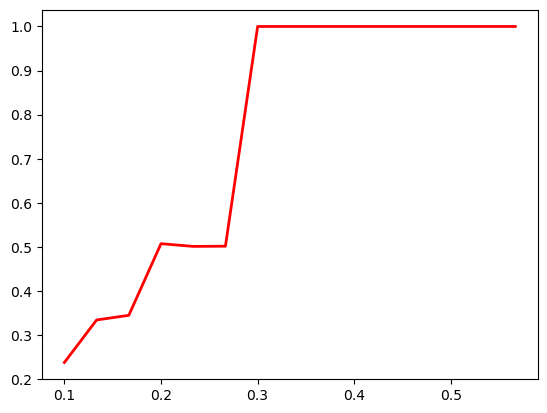

In [499]:
# FIG 2 PAPER
# PLOT METRIC AT DIFFERENT VALUES OF D

rng = np.random.default_rng(42)

start = time.time()

# run simulations
# x1, y1 = metric_d_data(metric=dispersion_index, net_type='scale_free', net_order=900, symmetric_updating=False,
#                        iterations=10000, sample_size=5, num_points=15, init_d=0.1, final_d=0.6, convergence=0.3, rng=rng)

x2, y2 = metric_d_data(metric=dispersion_index, net_type='complete_mixing', net_order=900, symmetric_updating=True,
                       iterations=12000, sample_size=5, num_points=15, init_d=0.1, final_d=0.6, convergence=0.3, rng=rng)

total_time = round(time.time()-start, 3)
print(f"simulation time: {total_time} seconds")

# generate plot
fig, ax = plt.subplots()
#ax.plot(x1, y1, linewidth=2.0, color='green')
ax.plot(x2, y2, linewidth=2.0, color='red')
plt.show()

simulation time: 34.22 seconds


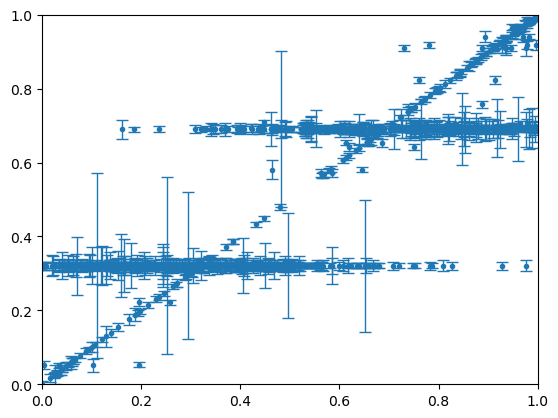

In [17]:
# FIG 4 PAPER
# OPINION CHANGE PLOT (requires many iterations)

# initialize rng and network
rng = np.random.default_rng(42)
net = nx.barabasi_albert_graph(n=900, m=2, seed=rng, initial_graph=nx.complete_graph(3))

start = time.time()

# run simulation
x, y, y_bar = opinion_change_data(G=net, iterations=300000, d=0.2, convergence=0.3, symmetric_updating=False, rng=rng)

total_time = round(time.time()-start, 3)
print(f"simulation time: {total_time} seconds")

# generate plot
fig, ax = plt.subplots()
ax.errorbar(x, y, y_bar, fmt='.', linewidth=1, capsize=4)
ax.set(xlim=(0, 1), ylim=(0, 1))
plt.show()

In [540]:
rng = np.random.default_rng(11)

graph = get_net('erdos', 900, rng, p=0.01)

start = time.time()

g, y, C, X = simulate_deffuant_model(graph, 20000, 0.01, 0.3, symmetric_updating=True, fast_mode=False, rng=rng, offset=-1)

total_time = round(time.time()-start, 3)
print(f"simulation time: {total_time} seconds")

/home/jacdals97/anaconda3/envs/csn_lab/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


simulation time: 19.617 seconds


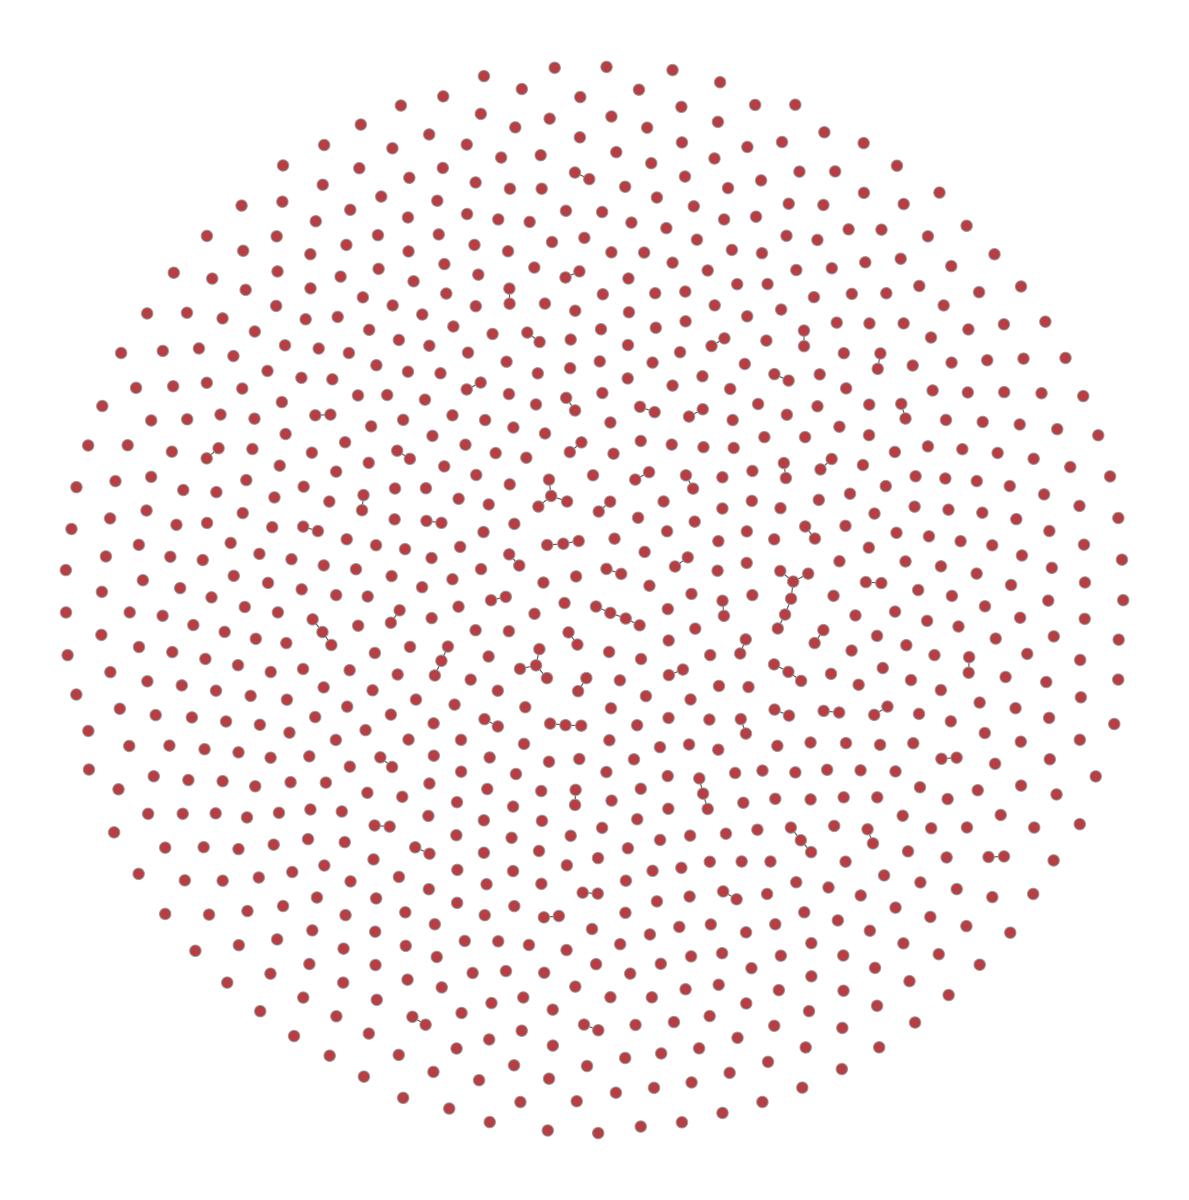

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f059a70b160, at 0x7f05a0523970>

In [545]:
from graph_tool import draw
draw.graph_draw(g)

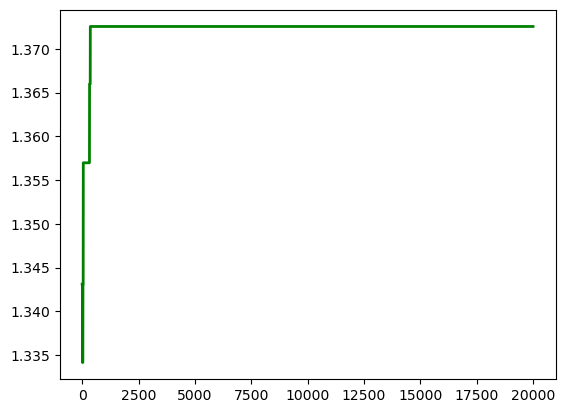

In [544]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(C)), C, linewidth=2.0, color='green')
plt.show()

##### Graph generation experiments

In [76]:
from scipy.sparse import random
from scipy.sparse import tril


def erdos_renyi_scipy(n, p, rng):
    """
    Generates an Erdos-Renyi random graph with n nodes and edge probability p.
    Returns a SciPy sparse matrix representing the adjacency matrix of the graph.
    """
    adj_matrix = random(n, n, density=p, format='csr', dtype="bool", random_state=rng, data_rvs=np.ones)
    adj_matrix = tril(adj_matrix)
    adj_matrix = adj_matrix + adj_matrix.T
    #adj_matrix.data = np.ones_like(adj_matrix.data)
    adj_matrix.setdiag(0)
    return adj_matrix.astype('bool').toarray()

def erdos_renyi(n, p, rng):
    """
    Generates an Erdos-Renyi random graph with n nodes and edge probability p.
    Returns a NumPy array representing the adjacency matrix of the graph.
    """
    adj_matrix = rng.random((n,n), dtype='float32')
    adj_matrix = np.tril(adj_matrix)
    adj_matrix += adj_matrix.T
    adj_matrix[adj_matrix > p] = 0
    adj_matrix[adj_matrix != 0] = 1
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix.astype("bool")


def erdos_renyi_bin(n, p, rng):
    """
    Generates an Erdos-Renyi graph with n nodes and edge probability p, where self-loops are not allowed.
    :param n: int, number of nodes in the graph
    :param p: float, probability of an edge between any two nodes
    :return: numpy array, adjacency matrix of the graph
    """
    adj_matrix = rng.binomial(1, p, size=(n, n))
    adj_matrix = np.tril(adj_matrix)
    adj_matrix += adj_matrix.T
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix.astype('bool')


def complete_adj(N):
    adj_matrix = np.ones((N,N), dtype="bool")
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix
    
    

#this function is not ready
def barabasi_albert_fast(n, m):
    """
    Generates a Barabasi-Albert random graph with n nodes and m edges per new node.
    Returns a NumPy array representing the adjacency matrix of the graph.
    """
    # Initialize the graph with m edges between m nodes
    graph = np.zeros((n,n), dtype='bool')
    graph[np.arange(m), np.random.choice(np.arange(m), size=m, replace=False)] = 1
    graph = graph + graph.T
    np.fill_diagonal(graph, 0)
    # Add new nodes with m edges
    for i in range(m, n):
        # Select m edges with probability proportional to degree
        prob = np.sum(graph, axis=1)/np.sum(np.sum(graph, axis=1))
        new_edges = np.random.choice(np.arange(n), size=m, p=prob)
        graph[i, new_edges] = 1
        graph[new_edges, i] = 1
        graph[i, i] = 0
    return graph


def adj_matrix_to_edge_list(adj_matrix):
    edge_list = np.column_stack(np.where(np.tril(adj_matrix) == 1))
    return edge_list


rng = np.random.default_rng(42)


In [49]:
start = time.time()
ER_sci = erdos_renyi_scipy(10000, p = 0.001, rng = rng)
total_time = round(time.time()-start, 3)
print(f"scipy time: {total_time} seconds")

start = time.time()
ER_num = erdos_renyi_graph(10000, p = 0.001, rng = rng)
total_time = round(time.time()-start, 3)
print(f"numpy time: {total_time} seconds")

start = time.time()
ER_num = erdos_renyi(10000, p = 0.001, rng = rng)
total_time = round(time.time()-start, 3)
print(f"numpy time: {total_time} seconds")

print(f"Scipy size = {ER_sci.data.nbytes} \n Numpy size = {ER_num.nbytes}")

scipy time: 0.259 seconds
numpy time: 4.481 seconds
numpy time: 2.499 seconds
Scipy size = 100000000 
 Numpy size = 100000000


In [306]:
N = 10
from graph_tool.generation import complete_graph

# test = np.random.binomial(1, 0.001, size=(N, N))
# test = np.ones((N,N), dtype="bool")
# np.fill_diagonal(test, 0)

# opinions = rng.random(N)

# test = erdos_renyi_scipy(N, 0.1, rng=rng)
# e_list = adj_matrix_to_edge_list(test)
# g = Graph(directed=False)
# g.add_edge_list(e_list)

g = complete_graph(N)

components = g.new_vertex_property('int')
e_prop = g.new_edge_property('bool')
e_prop.a = True

e_prop2 = g.new_edge_property('bool')
e_prop2.a = True


# start = time.time()
# res = [0]*10000
# for i in range(10000):
#     res[i] = dispersion_index(g, components)

# total_time = round(time.time()-start, 3)
# print(f"numpy time: {total_time} seconds")

# start2 = time.time()
# res = []
# for i in range(10000):
#     res.append(dispersion_index(g, components))

# total_time2 = round(time.time()-start2, 3)
# print(f"numpy time: {total_time2} seconds")



vprop = g.new_vertex_property('double')
vprop.a = rng.random(g.num_vertices())



for u in range(10):
    neigh_u = g.get_all_edges(u, [e_prop, g.edge_index])

    #eff_edges.a[neigh_u[:,3]]

    distances = distances = vprop.a[neigh_u[:,1]] - vprop.a[u]

    #distances = opinions - opinions[0] # vector of opinion distances
    distances[(distances < -0.3) | (distances > 0.3)] = -1 # turn nodes at dist>d into -1
    distances[distances != -1] = 0 # the rest into 0
    distances += 1 # close nodes are now 1 and far away ones are 0

    distances = distances.astype("uint8")

    e_prop.a[neigh_u[:,3]]   = distances

e_prop.a.sum()

# # start = time.time()
# # temp_edges =  g.get_edges([e_prop])

# # u = get_random_node_uniform(rng, temp_edges[temp_edges[:,2]==1][:,0])
# # total_time = round(time.time()-start, 3)
# # print(f"numpy time: {total_time} seconds")

# # start = time.time()
# # edge_id = get_random_node_uniform(rng, edge_index.a[e_prop.a==1])
# # u = g.get_edges()[edge_id,0]
# # total_time = round(time.time()-start, 3)
# # print(f"numpy time: {total_time} seconds")

e_prop.a
#g.set_edge_filter(e_prop)


# e_prop.a = True

# g.get_all_edges(u)

PropertyArray([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
               0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
               1, 1, 0, 0, 1], dtype=uint8)

In [77]:
N = 10000

start = time.time()
# test = np.ones((N,N), dtype="bool")
# np.fill_diagonal(test, 0)
test = erdos_renyi_scipy(N, 0.001, rng=rng)
e_list = adj_matrix_to_edge_list(test)
g = Graph(directed=False)
g.add_edge_list(e_list)
total_time = round(time.time()-start, 3)
print(f"numpy time: {total_time} seconds")

start = time.time()
# test = np.ones((N,N), dtype="bool")
# np.fill_diagonal(test, 0)
test = erdos_renyi_bin(N, 0.001, rng=rng)
e_list = adj_matrix_to_edge_list(test)
g = Graph(directed=False)
g.add_edge_list(e_list)
total_time = round(time.time()-start, 3)
print(f"numpy time: {total_time} seconds")


/home/jacdals97/anaconda3/envs/csn_lab/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


numpy time: 0.905 seconds
numpy time: 6.065 seconds


In [75]:
import networkit as nk
import sys
from graph_tool.generation import complete_graph
from graph_tool import Graph
from graph_tool.generation import random_graph
from graph_tool.spectral import adjacency
#from graph_tool import draw
from networkit.algebraic import adjacencyMatrix
import time

N = 10000

start = time.time()
test = erdos_renyi_scipy(N, 0.001, rng=rng)
e_list = adj_matrix_to_edge_list(test)
g_ = Graph(directed=False)
g_.add_edge_list(e_list)
total_time = round(time.time()-start, 3)
print(f"numpy time: {total_time} seconds")

def erdos_sample(n, p):
    return (np.random.binomial(n, p))

start = time.time()
g = random_graph(N, lambda: erdos_sample(N, 0.1), directed = False)
total_time = round(time.time()-start, 3)
print(f"numpy time: {total_time} seconds")

#draw.graph_draw((g_))


numpy time: 0.944 seconds
numpy time: 16.846 seconds


In [9]:
N = 5000

start = time.time()
test = complete_adj(N)
e_list = adj_matrix_to_edge_list(test)
g = Graph(directed=False)
g.add_edge_list(e_list)
total_time = round(time.time()-start, 3)
print(f"gt time: {total_time} seconds")

start = time.time()
g = complete_graph(N)
total_time = round(time.time()-start, 3)
print(f"gt time: {total_time} seconds")

gt time: 2.945 seconds
gt time: 1.776 seconds


In [143]:
from graph_tool.topology import label_components

start = time.time()
_, comp = label_components(g, components)
total_time = round(time.time()-start, 3)
print(f"gt time: {total_time} seconds")
components

gt time: 0.003 seconds


<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f05b95d9d00, at 0x7f05ba0c7fd0>

In [3]:
from numba import jit

def Reciprocity(adjmatrix):
    """Computes the fraction of reciprocal links to total number of links.
    Both weighted and unweighted input matrices are permitted. Weights
    are ignored for the calculation.
    Parameters
    ----------
    adjmatrix : ndarray of rank-2
        The adjacency matrix of the network.
    Returns
    -------
    reciprocity : float
        A scalar value between 0 (for acyclic directed networks) and 1 (for
        fully reciprocal).
    """
    # 0) PREPARE FOR COMPUTATIONS
    adjmatrix = adjmatrix.astype('bool')

    # 1) COMPUTE THE RECIPROCITY
    L = adjmatrix.sum()
    if L == 0:
        reciprocity = 0
    else:
        # Find the assymmetric links
        # Rest = np.abs(adjmatrix - adjmatrix.T)
        Rest = np.abs(adjmatrix ^ adjmatrix.T)
        Lsingle = 0.5*Rest.sum()
        reciprocity = np.float(L-Lsingle) / L

    return reciprocity

def FloydWarshall_Numba(adjmatrix, weighted_dist=False):
    """Computes the pathlength between all pairs of nodes in a network.
    WARNING! This version returns the same output as 'FloydWarshall()'
        function in main metrics.py module but runs much faster (for networks
        of N > 100). It requires package Numba to be installed.
    Parameters
    ----------
    adjmatrix : ndarray of rank-2
        The adjacency matrix of the network.
    weighted_dist : boolean, optional
        If True, if the graph distances are computed considering the weights
        of the links. False, otherwise. If 'adjmatrix' is a weighted
        network but'weighted_dist = False', the weights of the links are
        ignored.
    Returns
    -------
    distmatrix : ndarray of rank-2
        The pairwise distance matrix dij of the shortest pathlength between
        nodes i and j.
    See Also
    --------
    FloydWarshall : Computes the pathlength between all pairs of nodes.
    """
    # 0) DEFINE THE CORE OF THE FW ALGORITHM, ACCELARATED BY 'Numba'
    @jit
    def FW_Undirected(distmatrix):
        """The Floyd-Warshall algorithm for undirected networks
        """
        N = len(distmatrix)
        for k in range(N):
            for i in range(N):
                for j in range(i,N):
                    d = distmatrix[i,k] + distmatrix[k,j]
                    if distmatrix[i,j] > d:
                        distmatrix[i,j] = d
                        distmatrix[j,i] = d

    @jit
    def FW_Directed(distmatrix):
        """The Floyd-Warshall algorithm for directed networks
        """
        N = len(distmatrix)
        for k in range(N):
            for i in range(N):
                for j in range(N):
                    d = distmatrix[i,k] + distmatrix[k,j]
                    if distmatrix[i,j] > d:
                        distmatrix[i,j] = d

    ########################################################################
    # 1) PREPARE FOR THE CALCULATIONS
    # 1.1) Initialize the distance matrix
    if weighted_dist:
        distmatrix = np.where(adjmatrix == 0, np.inf, adjmatrix)
    else:
        distmatrix = np.where(adjmatrix == 0, np.inf, 1)

    # 1.2) Find out whether the network is directed or undirected
    recip = Reciprocity(adjmatrix)

    # 2) RUN THE FLOYD-WARSHALL ALGORITHM USING FASTER FUNCTIONS (NUMBA)
    if recip==1.0:
        FW_Undirected(distmatrix)
    else:
        FW_Directed(distmatrix)

    return distmatrix

def ConnectedComponents(distmatrix, directed=False, showall=True):
    """Finds all the connected components in a network out of a distance
    matrix.
    A strongly connected component is a set of nodes for which there is
    at least one path connecting every two nodes within the set.
    The function works both for directed and undirected networks, provided
    the adequate distance matrix is given.
    Parameters
    ----------
    distmatrix : ndarray of rank-2
        The pairwise graph distance matrix of the network, usually the
        output of function FloydWarshall().
    directed : boolean, optional
        'True' if the network is directed, 'False' if it is undirected.
    showall : boolean, optional
        If 'True' the function returns all strong components, including
        independent nodes. If 'False' it returns only components of two
        or more nodes.
    Returns
    -------
    components : list
        A list containing the components as ordered lists of nodes.
    See Also
    --------
    FloydWarshall : Pairwise graph distance between all nodes of a network.
    """
    N = len(distmatrix)

    # 1) Detect nodes that are connected in both directions
    newmatrix = np.where(distmatrix < N, 1, 0)

    # If network is directed, consider only pairs with a reciprocal path
    if directed:
        newmatrix = newmatrix * newmatrix.T

    # 2) Sort the nodes into their components
    # nodelist = range(N)
    nodelist = np.arange(N).tolist()
    components = []
    while nodelist:
        # Take the first node. This helps keeping the output sorted
        node = nodelist[0]
        if newmatrix[node,node]:
            # Find the component to which the node belongs to
            comp = list(newmatrix[node].nonzero()[0])
            components.append(comp)
            # Remove nodes in comp from nodelist
            for neigh in comp:
                nodelist.remove(neigh)
            # Clean trash
            del comp
        else:
            # The node is independent. Remove from list and continue
            if showall:
                components.append([node])
            nodelist.remove(node)
            continue

    del newmatrix
    return components

In [1]:
N = 100

#test = np.random.binomial(1, 0.001, size=(N, N))
test = np.ones((N,N), dtype="bool")
np.fill_diagonal(test, 0)


ConnectedComponents(FloydWarshall_Numba(test))

NameError: name 'np' is not defined

In [2]:
print(nx.__version__)

3.0


### Following code is a sparse matrix implementation

In [ ]:

def get_random_node_uniform(rng, a_huge_key_list):
    L = len(a_huge_key_list)
    i = rng.integers(0, L)
    return a_huge_key_list[i]

def get_net(net_type, net_order, rng=None):
    if net_type == 'scale_free':
        return nx.barabasi_albert_graph(n=net_order, m=2, seed=rng, initial_graph=nx.complete_graph(3))

    elif net_type == 'complete_mixing':
        return nx.complete_graph(n=net_order)

    elif net_type == 'lattice':
        return nx.grid_2d_graph(int(np.sqrt(net_order)), int(np.sqrt(net_order)), periodic=False)

    else:
        return None


def update_opinions(u, v, opinions, convergence, symmetric_updating=True):
    diff = opinions[u] - opinions[v]

    opinions[u] -= convergence * diff
    
    if symmetric_updating:
        opinions[v] += convergence * diff
        
    return opinions


def effective_neighbors(u, adjG, opinions, threshold):
    
    distances = opinions - opinions[u] # vector of opinion distances
    distances[(distances < -threshold) | (distances > threshold)] = -1 # turn nodes at dist>d into -1
    distances[distances != -1] = 0 # the rest into 0
    distances += 1 # close nodes are now 1 and far away ones are 0
    
    return adjG[[u],:]*distances # filters out non-neighbors with close opinion distance


def update_effective_net(u, v, effective_net, adjG, opinions, threshold, symmetric_updating):
    
    neighbors = effective_neighbors(u, adjG, opinions, threshold)

    effective_net[[u],:]   = neighbors
    effective_net[:,[u]] = neighbors.transpose()
        
    if not symmetric_updating:
        return effective_net

    neighbors = effective_neighbors(v, adjG, opinions, threshold)
    
    effective_net[[v],:]   = neighbors
    effective_net[:,[v]] = neighbors.transpose()
            
    return effective_net


def simulate_deffuant_model(G: nx.Graph, iterations: int, threshold: float, convergence: float, initial_opinions=None,\
                            symmetric_updating=True, fast_mode=False, rng=np.random.default_rng(42)):
    """
    Simulates the Deffuant model on the given graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph on which to simulate the model.
    iterations : int
        The number of iterations to run the simulation for.
    threshold : float
        Threshold value for node interaction in the model.
    convergence : float
        The value used for updating opinions in the model.
    symmetric_updating: bool
        If True, at every timestep both nodes update their opinions.
        If False, at every timestep only the first selected node updates its opinion.
    fast_mode: bool
        If True, only the last effective network is returned and used throughout the simulation.
        If False, every effective network is saved and returned.

    Returns
    -------
    list[networkx.Graph]
        A list of graphs, where each graph represents the state of the network at a given time step.
    """
    
    # initialize opinions
    if initial_opinions is None:
        opinions = rng.random(G.order())
    else:
        opinions = np.copy(initial_opinions)
    
    # save adjacency matrix
    adjG = nx.adjacency_matrix(G)

    # get initial effective network
    effective_net = nx.adjacency_matrix(G)
    for u in G.nodes():
        # get 0-1 vector of neighbors at opinion distance <threshold
        neighbors = effective_neighbors(u, adjG, opinions, threshold)
        effective_net[[u],:]   = neighbors
        effective_net[:,[u]] = neighbors.transpose()
    if not fast_mode:
        # initialize the list of nets that will be returned
        network_history = [effective_net]
        opinion_history = [opinions]

    # run simulation
    for t in range(1, iterations):
        
        if not fast_mode:
            # copy last effective network
            effective_net = np.copy(network_history[t-1])
            opinions      = np.copy(opinion_history[t-1])

        # choose random node to update
        u = rng.choice(G.order())
        
        # get another node if u is isolated
        while not effective_net[[u],:].sum():
            u = rng.choice(G.order())
        
        # get a random neighbor of u
        v = get_random_node_uniform(rng, np.argwhere(effective_net[[u]:]==1))[0]

        # update their opinions
        opinions = update_opinions(u, v, opinions, convergence, symmetric_updating)
        
        # we now update the connections of these nodes in the effective network depending on
        # the opinions of their neighbors in the underlying network G
        effective_net = update_effective_net(u, v, effective_net, adjG, opinions, threshold, symmetric_updating)
        
        if not fast_mode:
            # add it to list
            network_history.append(effective_net)
            opinion_history.append(opinions)
    
    if fast_mode:
        return effective_net, opinions
    else:
        return network_history, opinion_history